In [1]:
import network_parts
import metrics
from network_parts import *
from metrics import *

import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import cv2 
import time
import tqdm

from tensorflow.keras.utils import plot_model
import os
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import PIL
import importlib
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import cv2 
import time
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import confusion_matrix
import nibabel as nib
from skimage.exposure import equalize_hist
from skimage.exposure import match_histograms
from tqdm import tqdm
from numpy import load
from numpy import zeros
from numpy import ones
import numpy as np
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
from os import listdir
from numpy import asarray
import matplotlib.pyplot as plt
import cv2
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# preparing dat
fold_number = 5
x_test = np.load(f'drive/MyDrive/data/covid/x_test{str(fold_number)}.npy').reshape(-1,256,256).astype('float16')
y_test = np.load(f'drive/MyDrive/data/covid/y_test{str(fold_number)}.npy').reshape(-1,2,256,256).astype('float16')


x_train = np.load(f'drive/MyDrive/data/covid/x_train{str(fold_number)}.npy').reshape(-1,256,256).astype('float16')
y_train = np.load(f'drive/MyDrive/data/covid/y_train{str(fold_number)}.npy').reshape(-1,2,256,256).astype('float16')

x_train, x_val, y_train , y_val= train_test_split(x_train,y_train,test_size= 0.2,random_state=47)
print('val :',len(x_val))

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

val : 565
(2256, 256, 256)
(699, 256, 256)
(2256, 2, 256, 256)
(699, 2, 256, 256)


In [ ]:
tempx = []
templ = []
tempc = []
for i in range(len(x_train)):
  if y_train[i,1].sum() > 300 and np.mean(x_train[i]) < 0.07:
    # tempx.append(x_train[i].reshape(256,256))
    # templ.append(y_train[i,0].reshape(256,256))
    # tempc.append(y_train[i,1].reshape(256,256))
    mask = np.uint8(y_train[i,1]*255).copy()
    covid = np.uint8(y_train[i,1]*x_train[i]*255).copy()
    res = np.concatenate([mask,covid],axis=1)
    cv2.imwrite(f'maps/train/{str(i)}.png',res)
len(tempx)

In [ ]:

 
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model
 
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g
 
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g
 
# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model
 
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]
 
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y
 
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y
 
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
  # select a sample of input images
  [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
  # generate a batch of fake samples
  X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
  # scale all pixels from [-1,1] to [0,1]
  X_realA = (X_realA + 1) / 2.0
  X_realB = (X_realB + 1) / 2.0
  X_fakeB = (X_fakeB + 1) / 2.0
  # plot real source images
  for i in range(n_samples):
  	pyplot.subplot(3, n_samples, 1 + i)
  	pyplot.axis('off')
  	pyplot.imshow(X_realA[i])
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(X_fakeB[i])
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
    pyplot.axis('off')
    pyplot.imshow(X_realB[i])
	# save plot to file
  filename1 = 'plot_%06d.png' % (step+1)
  pyplot.savefig(filename1)
  pyplot.close()
  # save the generator model
  filename2 = 'drive/MyDrive/weights/gan_fold5.h5'
  g_model.save(filename2)
  print('>Saved: %s and %s' % (filename1, filename2))
 
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=600, n_batch=16):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		#print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)
 
dataset = load_real_samples('maps_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
print(image_shape)
# define the models
image_shape = (256,256,3)
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

In [ ]:
for i in range(len(tempc)):
  t = tempc[i].copy()
  t = np.expand_dims(t,axis=2)
  t = np.repeat(t,3,axis=2)
  tempc[i] = t.copy()

c_aug = np.array(tempc).astype(np.float16)

In [ ]:
src_image = np.uint8(c_aug*255).copy()
src_image = (src_image - 127.5) / 127.5

src_image = src_image.reshape(len(tempc),256,256,3)

model = load_model('weights/gan_fold5.h5')
gen_image = model.predict(src_image)
gen_image = (gen_image + 1) / 2.0
gen_image = gen_image*2
aug_covid = np.zeros([len(tempc),256,256])
for i in range(len(gen_image)):
  aug_covid[i] = np.mean(gen_image[i],axis=2).copy()

In [ ]:
for i in range(len(tempc)):
  tempc[i] = np.mean(tempc[i],axis=2)

for i in range(len(tempx)):
  tempx[i] = np.where(tempc[i] == 1,aug_covid[i].copy(),tempx[i])

tempx = np.array(tempx)
tempc = np.array(tempc)
templ = np.array(templ)

tempx = tempx*tempc

In [ ]:
plt.imshow(aug_covid[12].astype(np.float32),'gray',vmin=0,vmax=1)

In [ ]:
del(aug_covid,gen_image,src_image)

In [ ]:
# X_train = np.zeros([x_train.shape[0],256,256])
Y_train = np.zeros([y_train.shape[0]+len(tempc),2,256,256])

X_train = np.concatenate([x_train,tempx],axis=0)
del(x_train,tempx)
y1 = np.concatenate([y_train[:,0],templ],axis=0)
y2 = np.concatenate([y_train[:,1],tempc],axis=0)
del(y_train)
del(templ,tempc)
del(model)

In [ ]:
Y_train[:,0] = y1
Y_train[:,1] = y2

In [ ]:
X_train = X_train.reshape(len(X_train), 256, 256,1).astype(np.float16)
Y_train = Y_train.astype(np.float16)

In [ ]:
k = 2277
plt.imshow(np.concatenate([Y_train[k,0].astype(np.float32),
                           X_train[k].reshape(256,256).astype(np.float32),
                           Y_train[k,1].astype(np.float32)],1),'gray',vmin=0,vmax=1)

(0.914, 0.0)

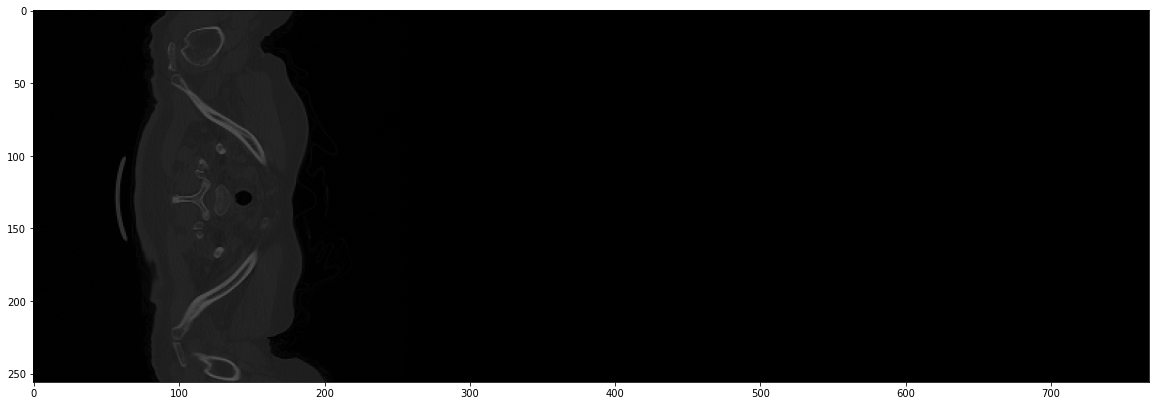

In [4]:
i=np.random.randint(len(x_train))


x1= x_train[i].reshape([256,256]).astype('float32')
x2= y_train[i,0].reshape([256,256]).astype('float32')
x3= y_train[i,1].reshape([256,256]).astype('float32')

plt.figure(figsize=(20,20))
plt.imshow(np.concatenate([x1,x2,x3],1),vmin=0,vmax=1,cmap='gray')
# plt.imshow(x1.reshape([256,256]),'gray',vmin=0,vmax=1)
x_train.max(), x_train.min()

In [3]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():    

    inp = Input([256,256,1])
    [E1,E2,E3,E4]=u_encoder(nOf_filters=[50,90,180,320,600],inp_layer=inp)                                                                     
                                                                                                  
    ###########
    #LUNG SEGMENTATION512
    ###########
    lung_fm = u_pipe([E1,E2,E3,E4],[16,32,50,64,128])
    out_lung = Conv2D( 1,1, activation = 'sigmoid', padding = 'same',
                      kernel_initializer = 'he_normal',name= 'lung')(lung_fm)
    ###########
    #COVID SEGMENTATION
    ###########
    covid_fm = u_pipe(nOf_filters=[50,70,128,256,512],encoder_lines=[E1,E2,E3,E4])
    drop = Dropout(0.3)(covid_fm)
    wire = Conv2D( 32,3, activation = 'relu', padding = 'same',
                       kernel_initializer = 'he_normal')(drop)
    wire = Conv2D( 16,3, activation = 'relu', padding = 'same',
                       kernel_initializer = 'he_normal')(wire)
    out_covid = Conv2D( 1,1, activation = 'sigmoid', padding = 'same',
                       kernel_initializer = 'he_normal',name= 'covid')(wire)
    
    ##########
    #FINALLY
    #########

    cc_F    = concatenate([covid_fm,out_covid,inp,E1],axis= 3,name='cc_F')
    mul     = mask_layer(inp_layer= cc_F,mask= out_lung)

    
    
    final   = xconv2D(32,3,inp_layer=mul)
    final   = Conv2D( 32,1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(final)
    final   = Conv2D( 16,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(final)
    final   = Conv2D( 1,1, activation = 'sigmoid', padding = 'same', kernel_initializer = 'he_normal',name='final')(final)

    xmtl = Model(inp,[out_lung,out_covid,final])
    xmtl.compile(optimizer=Adam(0.0004, decay=1e-4),loss = 'binary_crossentropy',
                 metrics= [f1_m],loss_weights=[1,1,2])
    xmtl.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
max pool (None, 128, 128, 1)
avg pool (None, 128, 128, 1)
concat (None, 128, 128, 2)
final  (None, 128, 128, 1)
max pool (None, 64, 64, 1)
avg pool (None, 64, 64, 1)
concat (None, 64, 64, 2)
final  (None, 64, 64, 1)
max pool (None, 32, 32, 1)
avg pool (None, 32, 32, 1)
concat (None, 32, 32, 2)
final  (None, 32, 32, 1)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 50) 500         input_1[0][0]                    
_____________________________________________________________

In [4]:
best_finder = ModelCheckpoint(filepath='drive/MyDrive/weights/res_attention_fold5.h5',monitor='val_final_f1_m', mode='max', verbose=1, save_best_only=True)

In [5]:
x_train=x_train.reshape(-1,256,256,1)
y_train=y_train.reshape(-1,2,256,256,1)
x_test=x_test.reshape(-1,256,256,1)
y_test=y_test.reshape(-1,2,256,256,1)
x_val=x_val.reshape(-1,256,256,1)
y_val=y_val.reshape(-1,2,256,256,1)

In [6]:
xmtl.load_weights('drive/MyDrive/weights/res_attention_fold5.h5')

In [11]:
history= xmtl.fit(x_train,[y_train[:,0],y_train[:,1],y_train[:,1]],
                  validation_data=(x_val,[y_val[:,0],y_val[:,1],y_val[:,1]]),
        epochs =24 ,batch_size=7,callbacks=[best_finder])

# history= xmtl.fit(x_train,[y_train[:,0],y_train[:,1],y_train[:,1]],epochs =60 ,batch_size=10)

Epoch 1/24
323/323 [==============================] - ETA: 0s - loss: 0.0297 - lung_loss: 0.0085 - covid_loss: 0.0087 - final_loss: 0.0063 - lung_f1_m: 0.9828 - covid_f1_m: 0.7793 - final_f1_m: 0.8319
Epoch 00001: val_final_f1_m improved from -inf to 0.81941, saving model to drive/MyDrive/weights/res_attention_fold5.h5
323/323 [==============================] - 820s 3s/step - loss: 0.0297 - lung_loss: 0.0085 - covid_loss: 0.0087 - final_loss: 0.0063 - lung_f1_m: 0.9828 - covid_f1_m: 0.7793 - final_f1_m: 0.8319 - val_loss: 0.0338 - val_lung_loss: 0.0080 - val_covid_loss: 0.0105 - val_final_loss: 0.0076 - val_lung_f1_m: 0.9838 - val_covid_f1_m: 0.7661 - val_final_f1_m: 0.8194
Epoch 2/24
323/323 [==============================] - ETA: 0s - loss: 0.0283 - lung_loss: 0.0079 - covid_loss: 0.0082 - final_loss: 0.0061 - lung_f1_m: 0.9836 - covid_f1_m: 0.7856 - final_f1_m: 0.8354
Epoch 00002: val_final_f1_m did not improve from 0.81941
323/323 [==============================] - 800s 2s/step - l

In [ ]:
plt.figure(figsize=[15,7])
plt.plot(history.history['final_f1_m'][:])
# plt.plot(history.history['val_final_dice_score'])
plt.plot(history.history['val_final_f1_m'][:])

history.history.keys()
len(history.history['loss'])

In [14]:
pred = xmtl.predict(x_val)
th = find_thresh(f1_m,y_val[:,1].astype(np.float32),pred[2].astype(np.float32))

0.05      0.778
0.1      0.811
0.15      0.83
0.2      0.842
0.25      0.852
0.3      0.859
0.35      0.865
0.4      0.869
0.45      0.872
0.5      0.873
0.55      0.873
0.6      0.872
0.65      0.869
0.7      0.864
0.75      0.856
0.8      0.847
0.85      0.832
0.9      0.81
0.95      0.769


In [7]:
temp = xmtl.predict(x_test)
pred = np.where(temp[2]>0.60,1,0).astype(np.bool)
# pred_l = temp[0]



Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


In [12]:
for i in range(len(pred)):
    if np.sum(pred[i]) < 80:
        pred[i] = 0

In [13]:
p = metricss(y_test[:,1],pred)

100%|██████████| 699/699 [00:22<00:00, 31.65it/s]

iou       :  0.737454433983476
f1_score  :  0.7986083496766728
ppv       :  0.8494818159813283
sensivity :  0.769597697022739
specifity :  0.9992141660307585
